# LLM-powered text classification

---
In this notebook, we'll continue working with the "PubMed 200k RCT dataset", but this time, we'll use a large language model to convert each sentence to a corresponding *embeddings* rather than using word counts.

Goals of the notebook are as follows:

- Load a pre-trained large language model (LLM) and see how it can be used to convert sentences into numeric vectors
- Train and evaluate a simple model that classifies sentences based on the embeddings given by the LLM

We'll need Huggingface and Pytorch to *embed* our sentences (as numeric vectors)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, shutil

The next couple of blocks will load the dataset. We've seen this code several times.

In [2]:
train_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/train.txt?raw=true'
val_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/dev.txt?raw=true'
test_url = 'https://github.com/Franck-Dernoncourt/pubmed-rct/raw/master/PubMed_20k_RCT/test.txt?raw=true'

In [3]:
def read_pubmed_rct(url, limit=10000):

    labels = []
    sentences = []
    i = 0
    
    with requests.get(url) as r:
        for line in r.iter_lines():
            if i >= limit:
                break
            fields = line.decode('utf-8').strip().split('\t')
            if len(fields) == 2:
                labels.append(fields[0])
                sentences.append(fields[1])
                i += 1
                
    return sentences, labels

s_train, l_train = read_pubmed_rct(train_url)
s_val, l_val = read_pubmed_rct(val_url)
s_test, l_test = read_pubmed_rct(test_url)

print('There are %i sentences in the training set' % len(s_train))
print('There are %i sentences in the validation set' % len(s_val))
print('There are %i sentences in the test set' % len(s_test))

There are 10000 sentences in the training set
There are 10000 sentences in the validation set
There are 10000 sentences in the test set


## Exercise 10.1: Sentence Length (in words)

Most of the time in natural language processing, we need to set a limit on how long are documents are allowed to be so that we can tell our model how big of an input it should expect. To get an initial sense of the length of our documents -- which in this case are sentences from PubMed abstracts -- let's plot a histogram of the sentence lengths (in words) for the sentences in our training set. Note that the length of a single sentence can be determined with `len(sentence.split())`.

In the code block below, you should:

1. Calculate the length of all sentences in `s_train` using a list comprehension
2. Use `plt.hist` to plot the lengths as a histogram

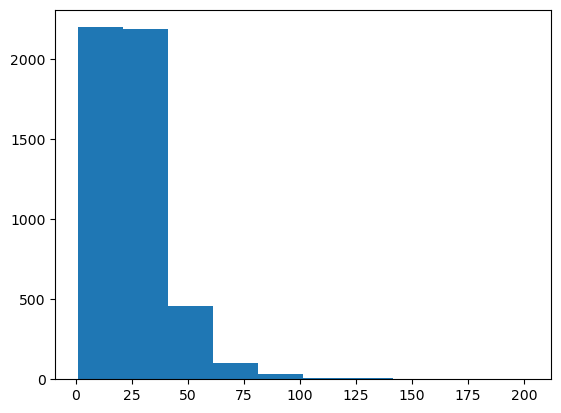

In [5]:
### CALCULATE THE LENGTH OF EACH SENTENCE ###

lengths = [len(s.split()) for s in s_train]

### CREATE A HISTOGRAM SHOWING SENTENCE LENGTH IN THE TRAINING SET ###

plt.hist(lengths)
plt.show()

## Sentence Embeddings

Now let's load a pre-trained large language model (LLM), Bio_ClinicalBERT, and use it to convert our sentences to embeddings, which are numeric vectors that encode the meaning of each sentence. We'll begin by loading the tokenizer, which converts sentences to a sequence of *tokens* (i.e., words or parts of words), as well as the model, which converts the sequences of tokens to a sequence of vectors.

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

Now, let's define a function that sequentially applies the tokenizer and model to convert a list of sentences to a numpy array of embeddings.

In [7]:
def embed_sentences(sentences, max_length=40):

    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=max_length)

    # Get the embeddings from the model
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()  # Mean pooling of token embeddings

    return embeddings

We can now embed our sentences! This step can take a few minutes.

In [ ]:
s_train_embedded = embed_sentences(s_train)
s_val_embedded = embed_sentences(s_val)
s_test_embedded = embed_sentences(s_test)

Let's take a look at the shape of the resulting numpy arrays. The first dimension is the number of sentences, and the second is the dimension (i.e., the number of numeric elements) in each sentence embedding.

In [ ]:
s_train_embedded.shape, s_val_embedded.shape, s_test_embedded.shape

## Exercise 10.2: A simple, LLM-powered sentence classifier

We're now ready to train our model. In the block below, you should:
1. Train `LogisticRegression` or another model of your choice (e.g. `MLPClassifier`) on the training set, then evaluate its performance on the validation set
2. (**optional**) Explore the effects of using (a) different classifiers, or (b) different LLM encoders

In [ ]:
from sklearn.neural_network import MLPClassifier

### TRAIN A MODEL OF YOUR CHOICE ON THE TRAINING SET ###

mlp_model = MLPClassifier(early_stopping=True).fit(s_train_embedded, l_train)

### EVALUATE PERFORMANCE ON THE VALIDATION SET ###

accuracy = np.mean(mlp_model.predict(s_val_embedded) == l_val)
print('The accuracy is %.1f' % (100 * accuracy))

## Steps to distribute your work as an html file:

If you're using Anaconda on your local machine:
- download your notebook as html (see `File > Download as > HTML (.html)`)

If you're using Google Colab:
- download your notebook as .ipynb (see `File > Download > Download .ipynb`)
- if you have nbconvert installed, convert it to .html and submit it in Talent LMS
- if not, you may need to place the .ipynb file in a .zip archive in order to distribute it (e.g. to upload or send via email)